In [1]:
#ALGORITHM = 'Linear Regression (Ridge)'
#ALGORITHM = 'KNN'
#ALGORITHM = 'Decision Tree'
#ALGORITHM = 'Random Forest'
#ALGORITHM = 'XG Boost'
ALGORITHM = 'CatBoost'
#ALGORITHM = 'Light Gradient Boosting'

ALGORITHM_DETAIL = 'random search'
#DATA_DETAIL = []
#DATA_DETAIL = ['explore param']
#DATA_DETAIL = ['no scale','no dummies']
DATA_DETAIL = ['no dummies'] if ALGORITHM.lower() == 'catboost' else ''
VERSION = '09'
#VERSION = '09'

RANDOM_STATE = 101
TRAINING_SIZE = 0.9

CROSS_VALIDATION_SCORING = 'r2'

print(f'ALGORITHM: {ALGORITHM}')
print(f'ALGORITHM_DETAIL: {ALGORITHM_DETAIL}')
print(f'DATA_DETAIL: {DATA_DETAIL}')
print(f'DATA VERSION: {VERSION}')


ALGORITHM: CatBoost
ALGORITHM_DETAIL: random search
DATA_DETAIL: ['no dummies']
DATA VERSION: 09


In [2]:
if ALGORITHM == 'CatBoost':
    %pip install catboost

if ALGORITHM == 'Light Gradient Boosting':
    %pip install lightgbm

Note: you may need to restart the kernel to use updated packages.


In [3]:
from sklearn.impute import SimpleImputer
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
import numpy as np
from pandas import DataFrame
import math
from termcolor import colored
from time import time
import sklearn
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.metrics import r2_score
import seaborn as sns
import pickle

import json
from datetime import datetime
import matplotlib.pyplot as plt

with open('../../z_envs/_envs.json') as f:
    env_vars = json.loads(f.read())
print(env_vars)

try:
    import google.colab

    run_env = 'colab'
except:
    try:
        run_env = env_vars['notebook_environment']
    except:
        run_env = 'unknown'

use_gpu = env_vars.get('use_gpu', False)
debug_mode = env_vars.get('debug_mode', False)
quick_mode = env_vars.get('quick_mode', False)
OVERRIDE_CV = env_vars.get('quick_override_cv_splits', None) if quick_mode else None
OVERRIDE_N_ITER = env_vars.get('quick_override_n_iter', None) if quick_mode else None
OVERRIDE_JOBS = env_vars.get('quick_override_n_jobs', None) if quick_mode else None
#if quick_mode:OVERRIDE_CV, OVERRIDE_N_ITER = 2, 10

already_timed = False
no_dummies = 'no dummies' in DATA_DETAIL
no_scaling = 'no scaling' in DATA_DETAIL
#not_catboost = 'catboost' not in ALGORITHM.lower() or not no_dummies
not_catboost = 'catboost' not in ALGORITHM.lower()

if run_env not in ['colab', 'gradient', 'cloud']:
    cloud_run = False
    from functions_b__get_the_data_20221116 import set_csv_directory
    set_csv_directory('final_split')
else:
    cloud_run = True
    import sys
    import os

    module_path = os.path.abspath(os.path.join('..', '..', '..'))
    if module_path not in sys.path:
        #sys.path.append(module_path+"\\zfunctions")
        sys.path.append(module_path)

from functions_0__common_20221116 import get_columns
from functions_b__get_the_data_20221116 import get_combined_dataset
from functions_d1__prepare_cleanse_data_20221116 import tidy_dataset
from functions_d2__transform_enrich_data_20221116 import preprocess, feature_engineer
from functions_d3__prepare_store_data_20221116 import create_train_test_data
from functions_e__train_model_20221116 import get_chosen_model, make_modelling_pipeline, get_cv_params, fit_model_with_cross_validation, get_hyperparameters
from functions_f_evaluate_model_20221116 import get_best_estimator_average_time, get_results, update_results



{'notebook_environment': 'gradient', 'use_gpu': True, 'debug_mode': False, 'quick_mode': False, 'quick_override_cv_splits': 2, 'quick_override_n_iter': 10, 'quick_override_n_jobs': 3}


In [4]:
#OVERRIDE_N_ITER = 5

In [5]:
#cutdown_rows = 1000
cutdown_rows = 0

LABEL = 'Price'

columns, booleans, floats, categories, custom, wildcard = get_columns(version=VERSION)

print(colored(f"features", "blue"), "-> ", columns)
columns.insert(0, LABEL)
print(colored(f"label", "green", None, ['bold']), "-> ", LABEL)

features ->  ['bedrooms', 'bathrooms', 'nearestStation', 'location.latitude', 'location.longitude', 'latitude_deviation', 'longitude_deviation', 'tenure.tenureType']
label ->  Price


In [6]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler


def make_pipeline():
    return Pipeline([
        #('mms', MinMaxScaler()),
        ('std_scaler', StandardScaler()),
        ('model', get_chosen_model(ALGORITHM))
    ])


starter_pipe = make_pipeline()
starter_pipe

Pipeline(steps=[('std_scaler', StandardScaler()), ('model', None)])

In [7]:
def get_source_dataframe(rows=cutdown_rows, folder_prefix='../../../'):
    retrieval_type = None

    filename = f'df_listings_v{VERSION}.csv'
    remote_pathname = f'https://raw.githubusercontent.com/jayportfolio/capstone_streamlit/main/data/final/{filename}'
    df_pathname_raw = folder_prefix + f'data/source/{filename}'
    df_pathname_tidy = folder_prefix + f'data/final/{filename}'

    if cloud_run:
        inDF = pd.read_csv(remote_pathname, on_bad_lines='error', index_col=0)
        retrieval_type = 'tidy'
        print('loaded data from', folder_prefix + remote_pathname)
    else:
        inDF = pd.read_csv(df_pathname_tidy, on_bad_lines='error', index_col=0)
        retrieval_type = 'tidy'
        print('loaded data from', df_pathname_tidy)

    if rows and rows > 0:
        inDF = inDF[:rows]
    return inDF, retrieval_type

In [8]:
df, retrieval_type = get_source_dataframe(folder_prefix='../../../')
df_orig = df.copy()

if retrieval_type != 'tidy':
    df = tidy_dataset(df, version=int(VERSION))
    df = feature_engineer(df, version=int(VERSION))

    df = df[columns]

print(df.shape)

loaded data from ../../../https://raw.githubusercontent.com/jayportfolio/capstone_streamlit/main/data/final/df_listings_v09.csv
(46871, 19)


In [9]:
df.head(30)

,Price,bedrooms,bathrooms,nearestStation,location.latitude,location.longitude,latitude_deviation,longitude_deviation,tenure.tenureType,feature__balcony,feature__chain free,feature__no onward chain,feature__off street parking,feature__one bedroom,feature__private balcony,feature__share of freehold,feature__three bedrooms,feature__two bedrooms,feature__two double bedrooms
14520525,550000.0,3.0,1.0,0.274316,51.529950,-0.207020,0.030230,0.102600,LEASEHOLD,0,0,0,0,0,1,0,0,0,0
27953107,400000.0,2.0,2.0,0.305845,51.549390,-0.482600,0.049670,0.378180,LEASEHOLD,1,0,0,0,0,0,0,0,0,1
33593487,579950.0,2.0,1.0,0.438045,51.447180,-0.338770,0.052540,0.234350,FREEHOLD,0,0,1,0,0,0,0,0,0,0
35271294,370000.0,2.0,1.0,0.399307,51.449568,-0.140154,0.050152,0.035734,LEASEHOLD,1,0,0,0,0,0,0,0,0,0
35429088,599950.0,2.0,1.0,0.238187,51.577030,-0.141230,0.077310,0.036810,NaN,0,0,0,0,0,0,0,0,0,0
44749111,475000.0,2.0,1.0,0.410550,51.370050,-0.212410,0.129670,0.107990,FREEHOLD,0,0,0,0,0,0,0,0,0,0
46204665,435000.0,3.0,2.0,0.314779,51.539070,-0.198935,0.039350,0.094515,LEASEHOLD,0,0,0,0,0,0,0,1,0,0
49020666,200000.0,1.0,1.0,0.875911,51.539959,-0.380863,0.040239,0.276443,LEASEHOLD,0,0,0,0,1,0,0,0,0,0
49036279,275000.0,2.0,1.0,0.474368,51.541780,0.037890,0.042060,0.142310,LEASEHOLD,0,0,0,0,0,0,0,0,0,0
49303873,450000.0,3.0,2.0,0.577040,51.524880,0.187200,0.025160,0.291620,FREEHOLD,0,0,0,0,0,0,0,0,0,0


In [10]:
df.isnull().sum()

Price                              0
bedrooms                           0
bathrooms                          0
nearestStation                     0
location.latitude                  0
location.longitude                 0
latitude_deviation                 0
longitude_deviation                0
tenure.tenureType               2744
feature__balcony                   0
feature__chain free                0
feature__no onward chain           0
feature__off street parking        0
feature__one bedroom               0
feature__private balcony           0
feature__share of freehold         0
feature__three bedrooms            0
feature__two bedrooms              0
feature__two double bedrooms       0
dtype: int64

In [11]:
df.info()
df.describe()
df.describe().T

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46871 entries, 14520525 to 126181118
Data columns (total 19 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Price                         46871 non-null  float64
 1   bedrooms                      46871 non-null  float64
 2   bathrooms                     46871 non-null  float64
 3   nearestStation                46871 non-null  float64
 4   location.latitude             46871 non-null  float64
 5   location.longitude            46871 non-null  float64
 6   latitude_deviation            46871 non-null  float64
 7   longitude_deviation           46871 non-null  float64
 8   tenure.tenureType             44127 non-null  object 
 9   feature__balcony              46871 non-null  int64  
 10  feature__chain free           46871 non-null  int64  
 11  feature__no onward chain      46871 non-null  int64  
 12  feature__off street parking   46871 non-null  int

,count,mean,std,min,25%,50%,75%,max
Price,46871.0,425069.390775,107227.324906,100000.000000,349950.000000,425000.000000,515000.000000,600000.000000
bedrooms,46871.0,1.992469,0.828837,1.000000,1.000000,2.000000,3.000000,7.000000
bathrooms,46871.0,1.182074,0.409879,1.000000,1.000000,1.000000,1.000000,5.000000
nearestStation,46871.0,0.438847,0.325942,0.000000,0.227169,0.367971,0.559620,7.197700
location.latitude,46871.0,51.497049,0.077085,51.298317,51.438861,51.499977,51.556183,51.683185
location.longitude,46871.0,-0.113269,0.156489,-0.498315,-0.210796,-0.102230,-0.010343,0.279726
latitude_deviation,46871.0,0.064317,0.042573,0.000000,0.028876,0.058595,0.094362,0.201403
longitude_deviation,46871.0,0.124202,0.095607,0.000000,0.043560,0.098984,0.192684,0.393895
feature__balcony,46871.0,0.038617,0.193124,0.000000,0.000000,0.000000,0.000000,2.000000
feature__chain free,46871.0,0.120266,0.325800,0.000000,0.000000,0.000000,0.000000,2.000000


In [12]:
old_length = len(df)

df = preprocess(df, version=VERSION)

print(f"dataframe contract due to cleaning: {old_length} ==> {len(df)}")
old_length = len(df)

df.describe().T

dataframe contract due to cleaning: 46871 ==> 46871


,count,mean,std,min,25%,50%,75%,max
Price,46871.0,425069.390775,107227.324906,100000.000000,349950.000000,425000.000000,515000.000000,600000.000000
bedrooms,46871.0,1.992469,0.828837,1.000000,1.000000,2.000000,3.000000,7.000000
bathrooms,46871.0,1.182074,0.409879,1.000000,1.000000,1.000000,1.000000,5.000000
nearestStation,46871.0,0.438847,0.325942,0.000000,0.227169,0.367971,0.559620,7.197700
location.latitude,46871.0,51.497049,0.077085,51.298317,51.438861,51.499977,51.556183,51.683185
location.longitude,46871.0,-0.113269,0.156489,-0.498315,-0.210796,-0.102230,-0.010343,0.279726
latitude_deviation,46871.0,0.064317,0.042573,0.000000,0.028876,0.058595,0.094362,0.201403
longitude_deviation,46871.0,0.124202,0.095607,0.000000,0.043560,0.098984,0.192684,0.393895
feature__balcony,46871.0,0.038617,0.193124,0.000000,0.000000,0.000000,0.000000,2.000000
feature__chain free,46871.0,0.120266,0.325800,0.000000,0.000000,0.000000,0.000000,2.000000


In [13]:
df.isna().sum()

Price                              0
bedrooms                           0
bathrooms                          0
nearestStation                     0
location.latitude                  0
location.longitude                 0
latitude_deviation                 0
longitude_deviation                0
tenure.tenureType               2744
feature__balcony                   0
feature__chain free                0
feature__no onward chain           0
feature__off street parking        0
feature__one bedroom               0
feature__private balcony           0
feature__share of freehold         0
feature__three bedrooms            0
feature__two bedrooms              0
feature__two double bedrooms       0
dtype: int64

In [14]:
df = df.dropna()
print(f"{old_length} ==> {len(df)}")
old_length = len(df)
df.describe()

46871 ==> 44127


,Price,bedrooms,bathrooms,nearestStation,location.latitude,location.longitude,latitude_deviation,longitude_deviation,feature__balcony,feature__chain free,feature__no onward chain,feature__off street parking,feature__one bedroom,feature__private balcony,feature__share of freehold,feature__three bedrooms,feature__two bedrooms,feature__two double bedrooms
count,44127.000000,44127.000000,44127.00000,44127.000000,44127.000000,44127.000000,44127.000000,44127.000000,44127.000000,44127.000000,44127.000000,44127.000000,44127.000000,44127.000000,44127.000000,44127.000000,44127.000000,44127.000000
mean,425224.642373,1.990981,1.18134,0.438522,51.496711,-0.113106,0.064544,0.123699,0.038865,0.121218,0.058898,0.047001,0.041834,0.040111,0.048428,0.059374,0.072586,0.096857
std,107203.332660,0.827621,0.40893,0.324152,0.077267,0.155863,0.042583,0.095220,0.193744,0.326940,0.235437,0.212071,0.200211,0.196338,0.214989,0.236326,0.259459,0.295919
min,100000.000000,1.000000,1.00000,0.000000,51.298317,-0.498315,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,349950.000000,1.000000,1.00000,0.227551,51.438303,-0.210633,0.029023,0.043551,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,425000.000000,2.000000,1.00000,0.368351,51.498780,-0.101910,0.058904,0.098750,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,515000.000000,3.000000,1.00000,0.559486,51.556343,-0.010854,0.094620,0.191727,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,600000.000000,7.000000,5.00000,7.197700,51.683185,0.279726,0.201403,0.393895,2.000000,2.000000,1.000000,2.000000,1.000000,2.000000,2.000000,1.000000,1.000000,2.000000


In [15]:
X_train, X_test, y_train, y_test, X_train_index, X_test_index, y_train_index, y_test_index, df_features, df_labels = create_train_test_data(
    df,
    categories=categories,
    RANDOM_STATE=RANDOM_STATE, return_index=True,
    drop_nulls=True,
    no_dummies=no_dummies
)

print(X_train[0])

if 'forest' in ALGORITHM.lower() or ALGORITHM.lower()=='light gradient boosting':
    y_train_orig = y_train
    y_train = y_train.ravel()
    print(y_train_orig, y_train)
    
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape, X_train_index.shape, X_test_index.shape,
      y_train_index.shape, y_test_index.shape)



[3.0 3.0 0.3166132574345781 51.45976 0.12939 0.0399600000000006 0.23381
 'FREEHOLD' 0 0 0 0 0 0 0 1 0 0]
(39714, 18) (4413, 18) (39714, 1) (4413, 1) (39714, 1) (4413, 1) (39714, 1) (4413, 1)


In [16]:
#imputer = SimpleImputer(strategy='mean')
#imputer.fit(X_train[6])
#X_train[6] = imputer.transform(X_train[6])

In [17]:
starter_model = starter_pipe[-1]

if not_catboost:
    default_model_params = starter_model.get_params()
    print("default_model_params:\n", default_model_params)
    print("---------------------")
    print("sklearn.metrics.get_scorer_names():\n",sklearn.metrics.get_scorer_names())

In [18]:
options_block = get_hyperparameters(ALGORITHM, use_gpu, prefix='../../../') #JHJH

if 'explore param' in DATA_DETAIL:
    def automl_step(param_options, vary):
        for key, value in param_options.items():
            #print(key, value, vary)
            if key != vary and key != 'model__' + vary:
                param_options[key] = [param_options[key][0]]
        return param_options

    #options_block = automl_step(options_block, "model__epochs")
    explore_param = "alpha"
    options_block = automl_step(options_block, explore_param)


if 'forest' in ALGORITHM.lower():
    OVERRIDE_N_ITER = 5
    if use_gpu:
        OVERRIDE_JOBS = 8

param_options, cv, n_jobs, refit, n_iter, verbose = get_cv_params(options_block, debug_mode=debug_mode,
                                                                  override_cv=OVERRIDE_CV,
                                                                  override_niter=OVERRIDE_N_ITER,
                                                                  override_njobs=OVERRIDE_JOBS)

if 'forest' in ALGORITHM.lower() or True: #JHJH
    verbose = 2

print("cv:", cv, "n_jobs:", n_jobs, "refit:", refit, "n_iter:", n_iter, "verbose:", verbose)

if not_catboost and len(param_options.keys()) > 2 and not already_timed and debug_mode:
    already_timed = True
    %timeit starter_pipe.fit(X_train, y_train)


print('\n\nHyperparameters:')
param_options if not_catboost else options_block

cv: 3 n_jobs: 3 refit: True n_iter: 100 verbose: 2


Hyperparameters:


{'learning_rate': [None, 0.01, 0.1, 1],
 'depth': [6, 7, 8],
 'l2_leaf_reg': [1, 3, 5, 7, 9]}

In [19]:
def fit_model_with_cross_validation(gs, X_train, y_train, fits):
    pipe_start = time()
    cv_result = gs.fit(X_train, y_train)
    gs.fit(X_train, y_train)
    pipe_end = time()
    average_time = round((pipe_end - pipe_start) / (fits), 2)

    print(f"Total fit/CV time      : {int(pipe_end - pipe_start)} seconds   ({pipe_start} ==> {pipe_end})")
    print()
    print(
        f'average fit/score time = {round(cv_result.cv_results_["mean_fit_time"].mean(), 2)}s/{round(cv_result.cv_results_["mean_score_time"].mean(), 2)}s')
    print(
        f'max fit/score time     = {round(cv_result.cv_results_["mean_fit_time"].max(), 2)}s/{round(cv_result.cv_results_["mean_score_time"].max(), 2)}s')
    print(f'refit time             = {round(cv_result.refit_time_, 2)}s')

    #return cv_result, average_time, cv_result.refit_time_, len(cv_result.cv_results_["mean_fit_time"])
    return average_time, cv_result.refit_time_, len(cv_result.cv_results_["mean_fit_time"])


if not_catboost:
    if ALGORITHM_DETAIL == 'grid search':
        crossval_runner = GridSearchCV(
            estimator=starter_pipe,
            param_grid=param_options,
            cv=cv, n_jobs=n_jobs, # get the AVX/AVX2 info if use n_jobs > 2
            verbose=verbose, scoring=CROSS_VALIDATION_SCORING,
            refit=refit,
            return_train_score=True, #n_iter=n_iter,
            #error_score='raise'
        )
    else:
        crossval_runner = RandomizedSearchCV(
            estimator=starter_pipe,
            param_distributions=param_options,
            cv=cv, n_jobs=n_jobs,  # get the AVX/AVX2 info if use n_jobs > 2
            verbose=verbose, scoring=CROSS_VALIDATION_SCORING,
            refit=refit,
            return_train_score=True,  #n_iter=n_iter,
            n_iter=n_iter,  # 1, #3
            #error_score='raise'
    )
    cv_average_fit_time, cv_best_model_fit_time, total_fits = fit_model_with_cross_validation(
        crossval_runner, X_train, y_train, fits=cv * n_iter)

else:
    import sys
    from catboost import CatBoostRegressor, Pool

    #pool = Pool(df, cat_features=['tenure.tenureType'], label=df['Price'].values)
    pool_Xytrain = Pool(X_train, cat_features=[7], label=y_train)
    #pool_Xtest = Pool(X_train, cat_features=[7], label=y_train)
    pool_Xtest = Pool(X_test, cat_features=[7], label=y_test)

    starter_model = model=CatBoostRegressor(iterations=n_iter, depth=3, learning_rate=0.1, loss_function='RMSE', objective='RMSE')

    output = starter_model.randomized_search(options_block,
                                             X=pool_Xytrain,
                                             cv=5,
                                             partition_random_seed=101,
                                             calc_cv_statistics=True,
                                             refit=True,
                                             shuffle=True,
                                             stratified=None,
                                             verbose=True,
                                             plot=True,

                                             log_cout=sys.stdout,
                                             log_cerr=sys.stderr
                                             #search_by_train_test_split=True,
                                             #train_size=0.8,
                                             #train_size=1,
                                             )

    cat_params, cat_cv_results = output['params'], output['cv_results']
    crossval_runner = {"best_params_": cat_params, "cv_results_": cat_cv_results, "best_estimator_": None}
crossval_runner


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 103788.1221990	test: 102797.4885665	best: 102797.4885665 (0)	total: 58.8ms	remaining: 5.82s
1:	learn: 85566.2644708	test: 85539.9475185	best: 85539.9475185 (1)	total: 70.5ms	remaining: 3.45s
2:	learn: 79924.4747349	test: 79778.5067841	best: 79778.5067841 (2)	total: 83.7ms	remaining: 2.71s
3:	learn: 73701.0635811	test: 73853.5836302	best: 73853.5836302 (3)	total: 95ms	remaining: 2.28s
4:	learn: 71845.7087987	test: 72159.7865442	best: 72159.7865442 (4)	total: 106ms	remaining: 2.02s
5:	learn: 70573.7214915	test: 70711.2539015	best: 70711.2539015 (5)	total: 122ms	remaining: 1.91s
6:	learn: 69578.5494465	test: 69491.4234296	best: 69491.4234296 (6)	total: 133ms	remaining: 1.76s
7:	learn: 69027.6006521	test: 69072.2993956	best: 69072.2993956 (7)	total: 144ms	remaining: 1.65s
8:	learn: 68620.4033189	test: 68914.1907195	best: 68914.1907195 (8)	total: 148ms	remaining: 1.5s
9:	learn: 68239.3671607	test: 68603.5220196	best: 68603.5220196 (9)	total: 153ms	remaining: 1.37s
10:	learn: 67797

{'best_params_': {'depth': 6, 'learning_rate': 1, 'l2_leaf_reg': 7},
 'cv_results_': defaultdict(list,
             {'iterations': [0,
               1,
               2,
               3,
               4,
               5,
               6,
               7,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19,
               20,
               21,
               22,
               23,
               24,
               25,
               26,
               27,
               28,
               29,
               30,
               31,
               32,
               33,
               34,
               35,
               36,
               37,
               38,
               39,
               40,
               41,
               42,
               43,
               44,
               45,
               46,


In [20]:
if not_catboost:
    best_estimator_pipe = crossval_runner.best_estimator_

    if not_catboost and debug_mode:
        crossval_runner.cv_results_

In [21]:
starter_model
if True:
    print(starter_model)
if not not_catboost:
    print(cat_params)
    print(cat_cv_results)

{'depth': 6, 'learning_rate': 1, 'l2_leaf_reg': 7}
defaultdict(<class 'list'>, {'iterations': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99], 'test-RMSE-mean': [97682.45336666817, 82061.66952395847, 75785.28613057059, 73546.1069765048, 72589.10177124778, 71686.44376027546, 71042.86131266589, 70542.7933075066, 69889.11228913073, 69318.33431020238, 68913.83202264435, 68652.43344951698, 68324.43205081357, 67942.73184231036, 67659.12163471818, 67312.63638534871, 67137.88273507831, 66946.99940461603, 66792.86809101538, 66674.75605979486, 66541.30410783531, 66388.60385231952, 66290.01837384189, 66127.95869062608, 66023.29393679481, 65920.3536019251, 6575

In [22]:
if not_catboost:
    crossval_runner.best_params_
else:
    crossval_runner["best_params_"]

In [23]:
if not_catboost:
    cv_results_df = pd.DataFrame(crossval_runner.cv_results_).sort_values('rank_test_score')
cv_results_df if not_catboost else ''

''

In [24]:
if not_catboost and debug_mode:
    xx = [c for c in cv_results_df.columns if 'param' in c]
    xx.insert(0, 'rank_test_score')
    xx.insert(0, 'mean_test_score')
cv_results_df[xx].head(7) if not_catboost and debug_mode else ''

''

In [25]:
cv_results_df[xx].tail(7) if not_catboost and debug_mode else ''

''

In [26]:
if not_catboost:
    cv_results_df['params2'] = cv_results_df['params'].apply(lambda l: '/'.join([str(c) for c in l.values()]))

    cv_columns = ['params2', 'rank_test_score', 'mean_test_score', 'mean_fit_time', 'mean_score_time', 'params']
    # if 'Neural' not in ALGORITHM:
    #     cv_columns.insert(2, 'mean_train_score')
    cv_results_df_full_sorted = cv_results_df.sort_values('rank_test_score')[cv_columns].reset_index(drop=True)

cv_results_df_full_sorted if not_catboost else ''

''

In [27]:
if not_catboost:

    cv_results_df_sorted = cv_results_df_full_sorted[cv_results_df_full_sorted['mean_test_score'] > -2]
    if len(cv_results_df_sorted) != len(cv_results_df_full_sorted):
        print(-len(cv_results_df_sorted) + len(cv_results_df_full_sorted), "fits were total failures")
        total_fits = len(cv_results_df_sorted)
cv_results_df_sorted if not_catboost else ''


''

In [28]:
#pd.set_option('display.max_columns', None)


In [29]:
if not_catboost:
    orig_debug_mode, orig_display_df_cols = debug_mode, pd.get_option('display.max_columns')
    debug_mode = True
    pd.set_option('display.max_columns', None)
    if debug_mode:
        debug_cols = ['rank_test_score', 'mean_test_score', 'mean_fit_time', 'mean_score_time']
        debug_cols.extend([c for c in cv_results_df.columns if 'param' in c])

cv_results_df[debug_cols].head(7) if debug_mode else ''

''

In [30]:
if not_catboost:
    debug_mode = orig_debug_mode
    pd.set_option('display.max_columns', orig_display_df_cols)

In [31]:
if not_catboost:
    def print_results(cross_validation_result):
        means = cross_validation_result.cv_results_['mean_test_score']
        stds = cross_validation_result.cv_results_['std_test_score']
        params = cross_validation_result.cv_results_['params']
        times = cross_validation_result.cv_results_['std_test_score']

        print("params:" + "/".join([c.replace("model__", "") for c in params[0].keys()]))
        print()
        for mean, std, param, time in zip(means, stds, params, times):
            #param2 = "/".join(list(param.values()))
            param2 = "/".join(list([str(c) for c in param.values()]))
            print(f'{round(mean, 3)} (+/-{round(std * 2, 3)}) in {round(time, 4)}s for {param2}')


print_results(crossval_runner) if debug_mode else ''

''

In [32]:
if not_catboost:
    print('Best Index: ', crossval_runner.best_index_)
    print('Best Score: ', crossval_runner.best_score_)
    print('Best Params: ', crossval_runner.best_params_)

In [33]:
#pool_Xtest.shape
#pool_Xtrain.shape
X_train[0]
X_test[0]

array([1.0, 1.0, 0.6959676001201812, 51.47824, -0.08707,
       0.0214800000000039, 0.01735, 'LEASEHOLD', 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0], dtype=object)

In [34]:
if not_catboost:
    y_pred = best_estimator_pipe.predict(X_test)
else:
    y_pred = starter_model.predict(pool_Xtest)

In [35]:
r_2_score = r2_score(y_test, y_pred)
if not_catboost:
    score = r_2_score
    default_score = best_estimator_pipe.score(X_test, y_test)
else:
    score = r_2_score
    default_score = starter_model.score(X_test, y_test)
score

0.6606217646329858

In [36]:
y_pred = y_pred.reshape((-1, 1))

R2 = r_2_score
MAE = mean_absolute_error(y_test, y_pred)
MSE = mean_squared_error(y_test, y_pred)
RMSE = math.sqrt(MSE)
print('-' * 10 + ALGORITHM + '-' * 10)
print('R square Accuracy', R2)
print('Mean Absolute Error Accuracy', MAE)
print('Mean Squared Error Accuracy', MSE)
print('Root Mean Squared Error', RMSE)

----------CatBoost----------
R square Accuracy 0.6606217646329858
Mean Absolute Error Accuracy 48121.96765021964
Mean Squared Error Accuracy 3833754208.2956886
Root Mean Squared Error 61917.31751534209


In [37]:
if debug_mode:
    print(y_test_index.reshape((-1, 1)).shape);
    print(y_pred.reshape((-1, 1)).shape);
    print(y_test.shape);
    print(y_test_index.shape);
    print(y_pred.shape);
    print(y_test.shape)

In [38]:
compare = np.hstack((y_test_index, y_test, y_pred))
compare_df = DataFrame(compare, columns=['reference', 'actual', 'predicted'])
compare_df['difference'] = abs(compare_df['actual'] - compare_df['predicted'])
compare_df['diff 1 %'] = abs((compare_df['actual'] - compare_df['predicted']) / compare_df['actual'] * 100)
compare_df['diff 2 %'] = abs((compare_df['actual'] - compare_df['predicted']) / compare_df['predicted']) * 100
compare_df['reference'] = compare_df['reference'].astype(int)
compare_df.set_index('reference', inplace=True)
compare_df

,actual,predicted,difference,diff 1 %,diff 2 %
reference,,,,,
85490754,400000.0,339275.401481,60724.598519,15.181150,17.898320
119328242,369950.0,432134.908089,62184.908089,16.809003,14.390161
125716790,350000.0,352255.006510,2255.006510,0.644288,0.640163
122440040,549000.0,558020.726645,9020.726645,1.643120,1.616558
120508103,495000.0,488694.467031,6305.532969,1.273845,1.290281
...,...,...,...,...,...
68620869,475000.0,562128.334072,87128.334072,18.342807,15.499723
85735665,575000.0,500264.071669,74735.928331,12.997553,14.939296
125706338,400000.0,358392.879273,41607.120727,10.401780,11.609360


In [39]:
combined = compare_df.merge(df[columns], how='inner', left_index=True, right_index=True).sort_values(['diff 1 %'],
                                                                                                     ascending=False)
#pd.options.display.float_format = '{:.4f}'.format
combined[['predicted', 'actual', 'Price', 'bedrooms', 'bathrooms']] = combined[
    ['predicted', 'actual', 'Price', 'bedrooms', 'bathrooms']].astype(int)
combined['bedrooms'] = combined['bedrooms'].astype(int)
combined

,actual,predicted,difference,diff 1 %,diff 2 %,Price,bedrooms,bathrooms,nearestStation,location.latitude,location.longitude,latitude_deviation,longitude_deviation,tenure.tenureType
122265818,160000,474003,314003.285416,196.252053,66.244960,160000,3,1,0.166024,51.510420,-0.037730,0.010700,0.066690,FREEHOLD
85667184,122000,361116,239116.474582,195.997110,66.215886,122000,1,1,0.838896,51.540462,-0.280301,0.040742,0.175881,LEASEHOLD
109722224,108000,271560,163560.950674,151.445325,60.229923,108000,1,1,0.302667,51.406803,-0.261328,0.092917,0.156908,LEASEHOLD
83639617,190000,391079,201079.276819,105.831198,51.416500,190000,2,2,0.162816,51.491264,0.064660,0.008456,0.169080,LEASEHOLD
122821142,170000,349567,179567.119565,105.627717,51.368424,170000,2,1,0.093936,51.430690,0.024020,0.069030,0.128440,LEASEHOLD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85633383,410000,409851,148.670504,0.036261,0.036274,410000,2,1,1.691097,51.601518,-0.481818,0.101798,0.377398,FREEHOLD
114057983,450000,449850,149.340881,0.033187,0.033198,450000,1,1,0.444298,51.527740,-0.203500,0.028020,0.099080,LEASEHOLD
121460075,495000,495148,148.907081,0.030082,0.030073,495000,1,1,0.193575,51.514149,-0.306150,0.014429,0.201730,LEASEHOLD
124311893,375000,374912,87.508484,0.023336,0.023341,375000,1,1,0.076714,51.436867,-0.127361,0.062853,0.022941,LEASEHOLD


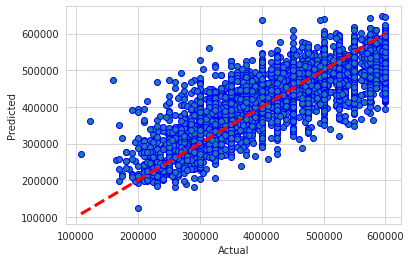

In [40]:
fig, ax = plt.subplots()
ax.scatter(y_test, y_pred, edgecolors=(0, 0, 1))
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=3)
ax.set_ylabel('Predicted')
ax.set_xlabel('Actual')
#ax.title.set_text(f'CV Chosen best option ({calculated_best_pipe[1]})')
plt.show()

In [41]:
if not_catboost:
    def custom_model_and_predictions(model, graph_params, X_train, y_train, X_test):
        graph_model = model
        graph_model.set_params(**graph_params)
        graph_model.fit(X_train, y_train)
        y_pred_graph = model.predict(X_test)

        return model, y_pred_graph


    best_model_count = 10 if not quick_mode else 2
    best_model_count = 3 if not quick_mode else 1
    best_models = {}
    best_model_predictions = {}
    best_model_scores = {}

    showable_increment = total_fits // (4 if not quick_mode else 2)
    if showable_increment==0:showable_increment=1
    for i in range(0, total_fits, showable_increment):
        if debug_mode or True: print(f'{i} ==> {i}')

        if i == 0:
            fitted_graph_model = crossval_runner.best_estimator_
            y_pred_graph = y_pred
        else:
            graph_pipe_params = cv_results_df_sorted['params'][i]
            print(graph_pipe_params)
            # would always return the best! graph_pipe_params = cv_results_df_sorted.loc[cv_results_df_sorted['rank_test_score'] == 1, 'params'].values[0]

            graph_params = {}
            for key, value in graph_pipe_params.items():
                graph_params[key.replace('model__', '')] = value

            fitted_graph_model, y_pred_graph = custom_model_and_predictions(make_pipeline(), graph_pipe_params, X_train,
                                                                            y_train, X_test)

        best_models[i] = fitted_graph_model[-1].get_params()
        best_model_predictions[i] = y_pred_graph
        best_model_scores[i] = fitted_graph_model.score(X_test, y_test)

    if debug_mode or True: print(f'{-1} ==> {-1}')
    graph_pipe_params = cv_results_df_sorted['params'][total_fits - 1]
    print(graph_pipe_params)
    graph_params = {}
    for key, value in graph_pipe_params.items():
        graph_params[key.replace('model__', '')] = value
    fitted_graph_model, y_pred_graph = custom_model_and_predictions(make_pipeline(), graph_pipe_params, X_train,
                                                                    y_train, X_test)
    best_models[-1] = fitted_graph_model[-1].get_params()
    best_model_predictions[-1] = y_pred_graph
    best_model_scores[-1] = fitted_graph_model.score(X_test, y_test)


In [42]:
cv_results_df_sorted if not_catboost else ''

''

In [43]:
cv_results_df_sorted['params']  if not_catboost and debug_mode else ''

''

In [44]:
cv_results_df_sorted['params'][0] if not_catboost else ''

''

In [45]:
best_models if not_catboost else ''

''

In [46]:
if not_catboost:
    for i in best_model_scores.keys():
        if i >= 0:
            plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=3)
            plt.scatter(y_test, best_model_predictions[i])
            # plt.title(str(i) + " " + str(round(best_model_scores[i], 4)) + " for " + str(best_models[i]))
            if len(best_models[i].keys()) < 30:
                plt.title(str(i) + " " + str(round(best_model_scores[i], 4)) + " for " + str(best_models[i]))
            else:
                plt.title(str(i) + " " + str(round(best_model_scores[i], 4)) + " for entry " + str(i))
            plt.show()

    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=3)
    plt.scatter(y_test, best_model_predictions[-1])
    # plt.title(str(i) + " " + str(round(best_model_scores[i], 4)) + " for " + str(best_models[i]))
    if len(best_models[i].keys()) < 30:
        plt.title(str(i) + " " + str(round(best_model_scores[-1], 4)) + " for " + str(best_models[-1]))
    else:
        plt.title(str(i) + " " + str(round(best_model_scores[-1], 4)) + " for (worst) entry " + str(i))

    plt.show()

In [47]:
if not_catboost:
    sns.set_theme(font_scale=2, rc=None)
    sns.set_theme(font_scale=1, rc=None)

    fig, axes = plt.subplots(ncols=3, figsize=(15, 5))

    plt.subplots_adjust(hspace=0.2)
    plt.subplots_adjust(wspace=0.2)

    #.flatten()
    coordinates = axes[0]
    sns.lineplot(x=[y_test.min(), y_test.max()], y=[y_test.min(), y_test.max()], ax=axes[0], color='red')
    sns.scatterplot(x=y_test.flatten(), y=best_model_predictions[0].flatten(), ax=axes[0],
                    s=100).set(title=f'"BEST" model')

    sns.lineplot(x=[y_test.min(), y_test.max()], y=[y_test.min(), y_test.max()], ax=axes[1], color='red')
    sns.scatterplot(x=y_test.flatten(), y=best_model_predictions[-1].flatten(), ax=axes[1],
                    s=100).set(title=f'"WORST" model')

    sns.lineplot(x=[y_test.min(), y_test.max()], y=[y_test.min(), y_test.max()], ax=axes[2], color='red')
    sns.scatterplot(x=y_test.flatten(), y=best_model_predictions[-1].flatten(), ax=axes[2],
                    s=120, color='orange')
    sns.scatterplot(x=y_test.flatten(), y=best_model_predictions[0].flatten(), ax=axes[2],
                    s=30, alpha=0.6, color='black').set(
        title='best (black) vs worst (orange)')
    #title='best (orange) vs worst (black)')

    fig.tight_layout()
    plt.show()

In [48]:
if not_catboost:
    cv_best_model_fit_time = cv_results_df_sorted.iloc[0]["mean_fit_time"]
cv_best_model_fit_time if not_catboost else ''

''

In [49]:
# <catboost.core.CatBoostRegressor object at 0x7fb167387490>
# {'depth': 6}
# defaultdict(<class 'list'>, {'iterations': [0, 1, 2],
# 'test-RMSE-mean': [396884.9605444017, 359548.6632536235, 326027.84885587444],
# 'test-RMSE-std': [308.9495320039113, 260.0967808594464, 219.65856329246023],
# 'train-RMSE-mean': [396884.77936957515, 359542.3612912551, 326018.9404460669],
# 'train-RMSE-std': [91.44140078375503, 86.77961380623475, 69.4038638987425]})

cv_best_model_fit_time = cv_results_df_sorted.iloc[0]["mean_fit_time"] if not_catboost else 999

DD2 = "(" + ",".join(DATA_DETAIL) + ")" if len(DATA_DETAIL) >= 1 else ""
key = f'{ALGORITHM} (v{VERSION})'.lower()

method =  f"{ALGORITHM_DETAIL}{DD2}"

new_results = {
    '_score': score,
    'R square Accuracy': R2,
    'Mean Absolute Error Accuracy': MAE,
    'Mean Squared Error Accuracy': MSE,
    'Root Mean Squared Error': RMSE,
    '_train time': cv_best_model_fit_time,
    'random_state': RANDOM_STATE,
    'date': str(datetime.now()),
    '_params': crossval_runner.best_params_ if not_catboost else cat_params,
    '_method':method,
    'run_env': run_env
}

if run_env not in ['colab']:
    old_results_json = get_results()
    try:
        old_best_score = old_results_json[key]['best score']
    except:
        print(f"haven't scored this model yet: {ALGORITHM}")
        old_best_score = -999
    this_model_is_best = update_results(old_results_json, new_results, key)

print(key)

haven't scored this model yet: CatBoost
(debug:do nothing)
catboost (v09)


In [50]:
crossval_runner.best_estimator_  if not_catboost else ''

''

In [51]:
if this_model_is_best:
    with open(f'../../../models/optimised_model_{ALGORITHM}_v{VERSION}{DD2}.pkl', 'wb') as f:
        if not_catboost:
            pickle.dump(crossval_runner.best_estimator_, f)
        else:
            pickle.dump(starter_model, f)
        print('pickled new version of model')
        print(f"{old_results_json[key]['_score']} is new best score (it's better than {old_best_score})")
        #print(results_json[key]['_score'], 'is an improvement on', results_json[key]['second best score'])
else:
    print("not updated saved model, the previous run was better")
    print(old_results_json[key]['_score'], 'is worse than or equal to', old_best_score)


pickled new version of model
0.6606217646329858 is new best score (it's better than -999)


In [52]:
if 'tree' in ALGORITHM.lower() or 'forest' in ALGORITHM.lower() or 'boost' in ALGORITHM.lower():
    feature_importances = crossval_runner.best_estimator_[-1].feature_importances_ if not_catboost else starter_model.get_feature_importance()
    #std = np.std([tree.feature_importances_ for tree in model.estimators_], axis = 0)

    indices = np.argsort(feature_importances)[::-1]

    print('Feature Ranking:')

    for f in range(X_train.shape[1]):
        print('%d. features %d (%f)' % (f + 1, indices[f], feature_importances[indices[f]]),
              df_features.columns[indices[f] + 1])
else:
    print(f'{ALGORITHM} does not have feature_importances, skipping')

Feature Ranking:
1. features 0 (30.168130) bedrooms
2. features 5 (19.513097) latitude_deviation
3. features 6 (15.897939) longitude_deviation
4. features 4 (13.566416) location.longitude
5. features 3 (8.551551) location.latitude
6. features 7 (4.011372) tenure.tenureType
7. features 1 (3.699905) bathrooms
8. features 2 (3.538128) nearestStation
9. features 9 (0.340652) feature__chain free
10. features 8 (0.141803) feature__balcony
11. features 14 (0.137491) feature__share of freehold
12. features 13 (0.109243) feature__private balcony
13. features 10 (0.102732) feature__no onward chain
14. features 16 (0.067489) feature__two bedrooms
15. features 11 (0.052913) feature__off street parking
16. features 15 (0.042249) feature__three bedrooms
17. features 12 (0.040860) feature__one bedroom
18. features 17 (0.018031) feature__two double bedrooms


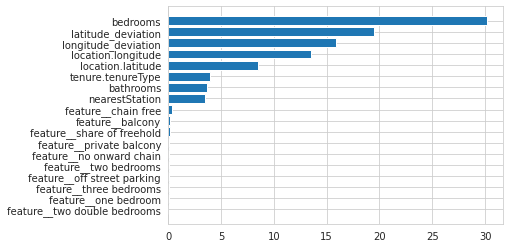

In [53]:
if 'tree' in ALGORITHM.lower() or 'forest' in ALGORITHM.lower() or 'boost' in ALGORITHM.lower():
    indices = np.argsort(feature_importances)

    fig, ax = plt.subplots()
    ax.barh(range(len(feature_importances)), feature_importances[indices])
    ax.set_yticks(range(len(feature_importances)))
    _ = ax.set_yticklabels(df_features.columns[[c + 1 for c in indices]])
else:
    print(f'{ALGORITHM} does not have feature_importances, skipping')